# **NLU final project - Barba Edoardo**
##Intent Classification and Slot Filling

In [13]:
# Global variables
import os
device = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
PAD_TOKEN = 0

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#Data preparation

Function to load dataset

In [16]:
import json
from pprint import pprint

def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

###Load ATIS train and test set

In [17]:
tmp_ATIS_train_raw = load_data(os.path.join('drive', 'MyDrive', 'data','ATIS','train.json'))
ATIS_test_raw = load_data(os.path.join('drive','MyDrive', 'data','ATIS','test.json'))
print('Train samples:', len(tmp_ATIS_train_raw))
print('Test samples:', len(ATIS_test_raw))

Train samples: 4978
Test samples: 893


In [18]:
pprint(tmp_ATIS_train_raw[0])

{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


###Load SNIPS train and test set


In [19]:
tmp_SNIPS_train_raw = load_data(os.path.join('drive', 'MyDrive', 'data','SNIPS','train.json'))
SNIPS_test_raw = load_data(os.path.join('drive','MyDrive', 'data','SNIPS','test.json'))
print('Train samples:', len(tmp_SNIPS_train_raw))
print('Test samples:', len(SNIPS_test_raw))

Train samples: 13084
Test samples: 700


In [20]:
pprint(tmp_SNIPS_train_raw[0])

{'intent': 'PlayMusic',
 'slots': 'O O B-artist O B-album O B-service I-service',
 'utterance': 'listen to westbam alumb allergic on google music'}


###Create validation set

In [21]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

def create_dev(tmp_train_raw, test_raw):

  portion = round(((len(tmp_train_raw) + len(test_raw)) * 0.10)/(len(tmp_train_raw)),2)

  intents = [x['intent'] for x in tmp_train_raw] 

  count_y = Counter(intents) 

  Y = []
  X = []
  mini_Train = []

  for id_y, y in enumerate(intents):
      if count_y[y] > 1: # Some intents have only one instance, we put them in training
          X.append(tmp_train_raw[id_y])
          Y.append(y)
      else:
          mini_Train.append(tmp_train_raw[id_y])
          
  # Random Stratify
  X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, 
                                                      random_state=42, 
                                                      shuffle=True,
                                                      stratify=Y)
  X_train.extend(mini_Train)
  train_raw = X_train
  dev_raw = X_dev

  y_test = [x['intent'] for x in test_raw]




  return train_raw, dev_raw, test_raw, y_train, y_dev, y_test
  #some intents are not present in train set!!!!!!!!!!!

In [22]:
ATIS_train_raw, ATIS_dev_raw, ATIS_test_raw, ATIS_y_train, ATIS_y_dev, ATIS_y_test = create_dev(tmp_ATIS_train_raw, ATIS_test_raw)

In [23]:
SNIPS_train_raw, SNIPS_dev_raw, SNIPS_test_raw, SNIPS_y_train, SNIPS_y_dev, SNIPS_y_test = create_dev(tmp_SNIPS_train_raw, SNIPS_test_raw)

In [24]:
def plot_data_distr(train_raw, dev_raw, test_raw, y_train, y_dev, y_test):
  #Number of labels 
  print("Number of Intent labels: ", len(Counter(y_train + y_test + y_dev)))
  
  # Intent distribution
  print('Train:')
  odict = {k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())}
  plt.barh(list(odict.keys()), odict.values(), align = 'center')
  plt.show()
  #pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
  print('Dev:')
  odict = {k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())}
  plt.barh(list(odict.keys()), odict.values(), align = 'center')
  plt.show()
  #pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
  print('Test:') 
  odict = {k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())}
  plt.barh(list(odict.keys()), odict.values())
  plt.show()
  #pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
  print('='*89)
  #print("train_raw[0]: ", train_raw[0])

  # Dataset size
  print('TRAIN size:', len(train_raw))
  print('DEV size:', len(dev_raw))
  print('TEST size:', len(test_raw))

###Intent distribution

ATIS

Number of Intent labels:  22
Train:


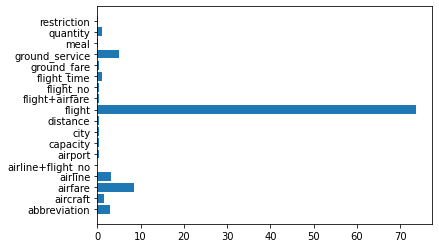

Dev:


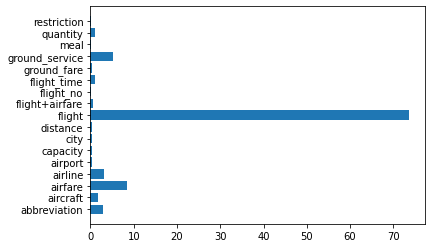

Test:


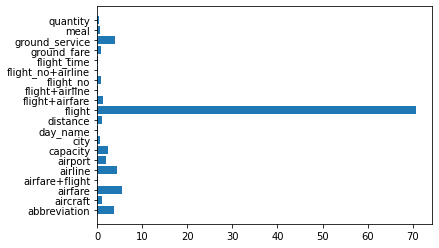

TRAIN size: 4381
DEV size: 597
TEST size: 893


In [25]:
plot_data_distr(ATIS_train_raw, ATIS_dev_raw, ATIS_test_raw, ATIS_y_train, ATIS_y_dev, ATIS_y_test)

SNIPS

Number of Intent labels:  7
Train:


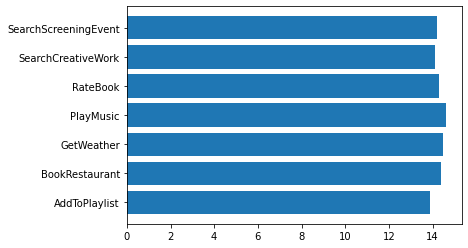

Dev:


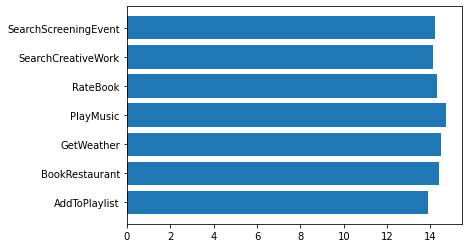

Test:


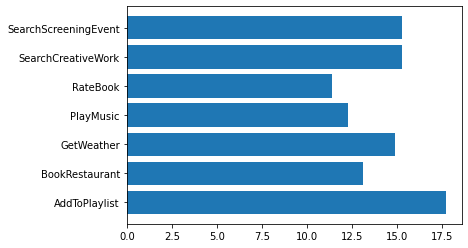

TRAIN size: 11644
DEV size: 1440
TEST size: 700


In [26]:
plot_data_distr(SNIPS_train_raw, SNIPS_dev_raw, SNIPS_test_raw, SNIPS_y_train, SNIPS_y_dev, SNIPS_y_test)

###Slot labels distribution

ATIS

Number of slot labels:  129
Train:


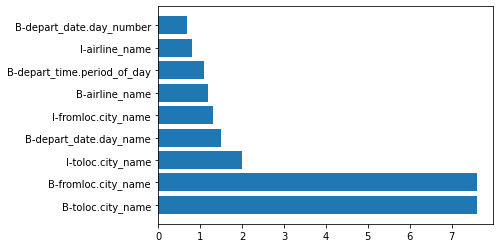

Dev:


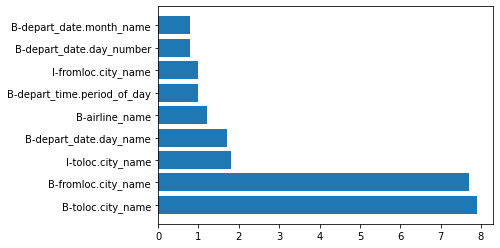

Test:


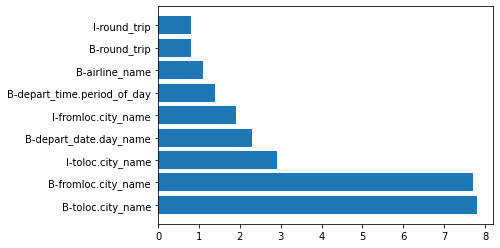

In [27]:
#slot distribution
train_slots = []
for sample in ATIS_train_raw:
  train_slots.extend(sample['slots'].split())

dev_slots = []
for sample in ATIS_dev_raw:
  dev_slots.extend(sample['slots'].split())

test_slots = []
for sample in ATIS_test_raw:
  test_slots.extend(sample['slots'].split())

print("Number of slot labels: ", len(Counter(train_slots + dev_slots + test_slots)))

ordered_train_slots = dict(sorted(Counter(train_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_dev_slots = dict(sorted(Counter(dev_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_test_slots = dict(sorted(Counter(test_slots).items(), key=lambda item: item[1], reverse=True)[:10])

print('Train:')
odict = {k:round(v/len(train_slots),3)*100 for k, v in ordered_train_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Dev:')
odict = {k:round(v/len(dev_slots),3)*100 for k, v in ordered_dev_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Test:') 
odict = {k:round(v/len(test_slots),3)*100 for k, v in ordered_test_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

SNIPS

Number of slot labels:  72
Train:


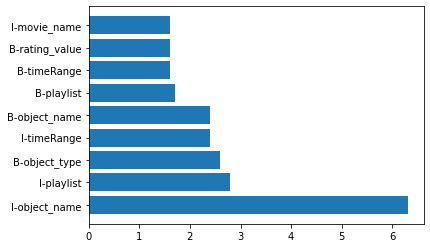

Dev:


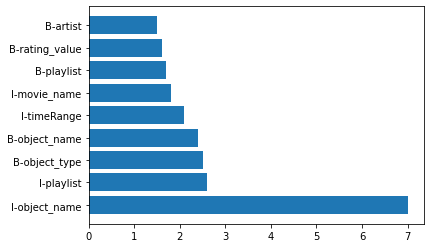

Test:


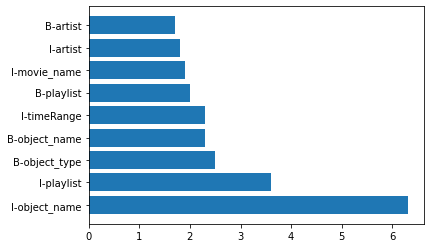

In [28]:
#Number of slot labels: 
#slot distribution
train_slots = []
for sample in SNIPS_train_raw:
  train_slots.extend(sample['slots'].split())

dev_slots = []
for sample in SNIPS_dev_raw:
  dev_slots.extend(sample['slots'].split())

test_slots = []
for sample in SNIPS_test_raw:
  test_slots.extend(sample['slots'].split())

print("Number of slot labels: ", len(Counter(train_slots + dev_slots + test_slots)))

ordered_train_slots = dict(sorted(Counter(train_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_dev_slots = dict(sorted(Counter(dev_slots).items(), key=lambda item: item[1], reverse=True)[:10])
ordered_test_slots = dict(sorted(Counter(test_slots).items(), key=lambda item: item[1], reverse=True)[:10])

print('Train:')
odict = {k:round(v/len(train_slots),3)*100 for k, v in ordered_train_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Dev:')
odict = {k:round(v/len(dev_slots),3)*100 for k, v in ordered_dev_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

print('Test:') 
odict = {k:round(v/len(test_slots),3)*100 for k, v in ordered_test_slots.items()}
odict.pop("O")
plt.barh(list(odict.keys())[:10], list(odict.values())[:10], align = 'center')
plt.show()

##Lang class

We use it to convert word,intent and slot to id and vice versa

In [29]:
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}

    #method to transform words to id 
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                #print("k: ", k)
                #print("v: ", v)
                #print("len(vocab): ", len(vocab))
                vocab[k] = len(vocab)
                #print("vocab[k]: ", vocab[k])
        #pprint(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

Create lang object of ATIS and SNIPS datasets

In [30]:
ATIS_words = sum([x['utterance'].split() for x in ATIS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
ATIS_corpus = ATIS_train_raw + ATIS_dev_raw + ATIS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
ATIS_slots = set(sum([line['slots'].split() for line in ATIS_corpus],[])) # the type of slots
ATIS_intents = set([line['intent'] for line in ATIS_corpus]) #all the intent types

ATIS_lang = Lang(ATIS_words, ATIS_intents, ATIS_slots, cutoff=0)

In [31]:
SNIPS_words = sum([x['utterance'].split() for x in SNIPS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
SNIPS_corpus = SNIPS_train_raw + SNIPS_dev_raw + SNIPS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
SNIPS_slots = set(sum([line['slots'].split() for line in SNIPS_corpus],[])) # the type of slots
SNIPS_intents = set([line['intent'] for line in SNIPS_corpus]) #all the intent types

SNIPS_lang = Lang(SNIPS_words, SNIPS_intents, SNIPS_slots, cutoff=0)

Now we can see how words, intent and slots are mapped into ids

In [32]:
print(ATIS_lang.word2id)
print(ATIS_lang.intent2id)
print(ATIS_lang.slot2id)

{'pad': 0, 'unk': 1, 'what': 2, 'type': 3, 'of': 4, 'aircraft': 5, 'does': 6, 'eastern': 7, 'fly': 8, 'from': 9, 'atlanta': 10, 'to': 11, 'denver': 12, 'before': 13, '6': 14, 'pm': 15, 'show': 16, 'me': 17, 'the': 18, 'fares': 19, 'dallas': 20, 'san': 21, 'francisco': 22, 'and': 23, 'flights': 24, 'pittsburgh': 25, 'philadelphia': 26, 'flight': 27, 'will': 28, 'originate': 29, 'boston': 30, 'are': 31, 'available': 32, 'on': 33, 'monday': 34, 'is': 35, 'first': 36, 'after': 37, '8': 38, 'am': 39, 'that': 40, 'arrive': 41, 'in': 42, 'afternoon': 43, 'give': 44, 'a': 45, 'list': 46, 'between': 47, 'oakland': 48, 'i': 49, 'need': 50, 'leaves': 51, 'late': 52, 'wednesday': 53, 'salt': 54, 'lake': 55, 'city': 56, 'there': 57, 'newark': 58, 'seattle': 59, 'saturday': 60, "'d": 61, 'like': 62, 'see': 63, 'all': 64, 'economy': 65, 'baltimore': 66, 'times': 67, 'for': 68, 'phoenix': 69, 'sfo': 70, 'let': 71, "'s": 72, 'how': 73, 'much': 74, 'would': 75, 'direct': 76, 'be': 77, 'may': 78, 'sevent

In [33]:
print(SNIPS_lang.word2id)
print(SNIPS_lang.intent2id)
print(SNIPS_lang.slot2id)

{'pad': 10605, 'unk': 1, 'can': 2, 'i': 3, 'get': 4, 'the': 5, 'showtimes': 6, 'for': 7, 'films': 8, 'at': 9, 'closest': 10, 'movie': 11, 'house': 12, 'book': 13, 'a': 14, 'restaurant': 15, 'in': 16, 'michigan': 17, '4': 18, 'people': 19, 'give': 20, '3': 21, 'out': 22, 'of': 23, '6': 24, 'to': 25, 'current': 26, 'textbook': 27, 'one': 28, 'stars': 29, 'shiva': 30, 'option': 31, 'need': 32, 'reservation': 33, 'five': 34, 'top-rated': 35, 'english': 36, 'elma': 37, 'please': 38, 'add': 39, 'track': 40, 'by': 41, 'david': 42, 'freiberg': 43, 'my': 44, 'workout': 45, 'playlist': 46, 'put': 47, 'on': 48, 'vimeo': 49, 'and': 50, 'play': 51, 'kacapi': 52, 'suling': 53, 'if': 54, 'you': 55, 'go': 56, 'table': 57, 'irma': 58, 'hotel': 59, 'mount': 60, 'repose': 61, 'which': 62, 'cinemark': 63, 'theatres': 64, 'is': 65, 'playing': 66, 'atom': 67, 'take': 68, 'me': 69, 'nine': 70, 'close': 71, 'westfield': 72, 'delaware': 73, 'when': 74, 'will': 75, 'boys': 76, 'next': 77, 'door': 78, 'be': 79, 

### Customize the Dataset class

In [34]:
import torch
import torch.utils.data as data

class IntentsAndSlots(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

#convert to numbers
        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample #dictionary with 3 keys
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [35]:
# Create our ATIS datasets
ATIS_train_dataset = IntentsAndSlots(ATIS_train_raw, ATIS_lang)
ATIS_dev_dataset = IntentsAndSlots(ATIS_dev_raw, ATIS_lang)
ATIS_test_dataset = IntentsAndSlots(ATIS_test_raw, ATIS_lang)

In [36]:
# Create our SNIPS datasets
SNIPS_train_dataset = IntentsAndSlots(SNIPS_train_raw, SNIPS_lang)
SNIPS_dev_dataset = IntentsAndSlots(SNIPS_dev_raw, SNIPS_lang)
SNIPS_test_dataset = IntentsAndSlots(SNIPS_test_raw, SNIPS_lang)

###Dataloader

In [37]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
        
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [38]:
# Dataloader ATIS instantiation
ATIS_train_loader = DataLoader(ATIS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
ATIS_dev_loader = DataLoader(ATIS_dev_dataset, batch_size=64, collate_fn=collate_fn)
ATIS_test_loader = DataLoader(ATIS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [39]:
# Dataloader SNIPS instantiation
SNIPS_train_loader = DataLoader(SNIPS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
SNIPS_dev_loader = DataLoader(SNIPS_dev_dataset, batch_size=64, collate_fn=collate_fn)
SNIPS_test_loader = DataLoader(SNIPS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [40]:
ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)
print("ATIS vocabulary len: ", ATIS_vocab_len)

ATIS vocabulary len:  863


In [41]:
SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)
print("SNIPS vocabulary len: ", SNIPS_vocab_len)

SNIPS vocabulary len:  10621


##Auxiliary methods

In [42]:
def init_weights(mat): #randomly initialize weights
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [43]:
def plot_losses(sampled_epochs, loss_train, loss_dev):
  plt.figure(num = 3, figsize=(12, 8)).patch.set_facecolor('white')
  plt.title('Train and Dev Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, loss_train, label='Train loss')
  plt.plot(sampled_epochs, loss_dev, label='Dev loss')
  plt.legend()
  plt.show()

#Baseline Model

As baseline model I took the LSTM model seen in class

##Model definition

In [44]:
class ModelIAS(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)     #network, unidirectional
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 

        #packed output containing the output features (h_t) from the last layer of the LSTM, 
        #for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the 
        #input, the output will also be a packed sequence.

        #last_hidden containing the final hidden state for each element in the sequence
        #cell containing the final cell state for each element in the sequence
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, classes 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

##Train Loop Definition

In [45]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [46]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())



        loss = loss_intent + loss_slot 

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
   
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
            
                utterance = [lang.id2word[elem] for elem in utt_ids]
            
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
           
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array

In [47]:
def train(train_loader, test_loader, dev_loader, model, optimizer, lang, n_epochs=200, patience=5):
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']
          
            #print('\nSlot F1: ', results_dev['total']['f'])
            #print('Intent Accuracy:', intent_res['accuracy'])
            
            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

Some hyperparameters

In [48]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate

Definition of loss for slots and intents

In [49]:
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN) #we want to ignore the padding token
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

###Train on ATIS

In [50]:
ATIS_model = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_model.apply(init_weights)
ATIS_optimizer = optim.Adam(ATIS_model.parameters(), lr=lr) #take default parameters, just modify lr

RuntimeError: ignored

In [ ]:
runs = 5
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
ATIS_tot_intent_test = []
ATIS_tot_results_test = []

for x in tqdm(range(0, runs)):
    
    ATIS_model = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model.apply(init_weights)
    ATIS_optimizer_adv = optim.Adam(ATIS_model.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model, 
        optimizer = ATIS_optimizer_adv,
        lang = ATIS_lang) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
    ATIS_tot_intent_test.append(intent_test)
    ATIS_tot_results_test.append(results_test)

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

###Intent classification analysis 

In [ ]:
x = ATIS_tot_intent_test[0]
print("Accuracy: ", x.pop('accuracy'))

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

10 best classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

10 worst classified intent labels (based on F1-score):

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = ATIS_tot_results_test[0]

15 best slot labels

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses plots 

Total loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

###Train on SNIPS

In [ ]:
runs = 5
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
SNIPS_tot_intent_test = []
SNIPS_tot_results_test = []
 
for x in tqdm(range(0, runs)):
    
    SNIPS_model_adv = ModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model_adv.apply(init_weights)
    SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_adv, 
        optimizer = SNIPS_optimizer_adv,
        lang = SNIPS_lang) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
    SNIPS_tot_intent_test.append(intent_test)
    SNIPS_tot_results_test.append(results_test)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))


###Intent classification analysis 

In [ ]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

Classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = SNIPS_tot_results_test[0]

15 best classified slot labels

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses plots

Total loss plot

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

Intent loss plot

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

Slot loss plot

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])

#Second model: Bi-LSMT Model

In [ ]:
class Model_adv(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(Model_adv, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   dropout=0.1,
                                   bidirectional=True)     #network, bidirectional

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        self.dropout = nn.Dropout(0.6)

        self.slot_out = nn.Linear(hid_size*2, out_slot)

        self.intent_out = nn.Linear(hid_size, out_int)
      
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size

        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

        utt_emb_drop = self.dropout(utt_emb)
        
        packed_input = pack_padded_sequence(utt_emb_drop, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        hidden_conv = last_hidden

        hidden_conv = hidden_conv[-1,:,:]

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(hidden_conv)
       
        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        slots = self.slot_out(drop_utt)

        intent = self.intent_out(drop_hidden)
       
        slots = slots.permute(1,2,0) # We need this for computing the loss

        return slots, intent

##Train Methods

Train loops that outputs also the intent and slot losses

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_adv(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())

        if random.random() > 0.8:
          alfa = random.random()
        else: 
          alfa = 0.3

        loss = alfa*loss_intent + (1-alfa)*loss_slot 

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop_adv(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
                #print(hyp_slots)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array


In [ ]:
def train_adv(train_loader, test_loader, dev_loader, model, criterion_slots, criterion_intents, optimizer, lang, n_epochs=200, patience=3, train=True):
 
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  last_loss = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop_adv(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop_adv(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']
            accuracy = intent_res['accuracy']
            #print('\nSlot F1: ', results_dev['total']['f'])
            #print('Intent Accuracy:', intent_res['accuracy'])
            

            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1

            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop_adv(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

Some hyperparameters

In [ ]:
emb_size = 400
hid_size = 400

lr = 0.0001

Losses definition

In [ ]:
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN) #we want to ignore the padding token
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

##Train on ATIS 

In [ ]:
runs = 5
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
ATIS_tot_intent_test = []
ATIS_tot_results_test = []

for x in tqdm(range(0, runs)):
    
    ATIS_model_adv = Model_adv(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model_adv.apply(init_weights)
    ATIS_optimizer_adv = optim.Adam(ATIS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model_adv, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = ATIS_optimizer_adv,
        lang = ATIS_lang,
        patience=5) 
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
    ATIS_tot_intent_test.append(intent_test)
    ATIS_tot_results_test.append(results_test)

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

###Intent classification analysis 

Accuracy

In [ ]:
x = ATIS_tot_intent_test[0]
x.pop('accuracy')

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

10 best classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

10 worst classified intent labels (based on F1-score):

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = ATIS_tot_results_test[0]

15 best classified slot labels

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses Plots 

Total loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot 

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

##Train on SNIPS

In [ ]:
runs = 5
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
 
for x in tqdm(range(0, runs)):

    SNIPS_model_adv = Model_adv(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model_adv.apply(init_weights)
    SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_adv, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = SNIPS_optimizer_adv,
        lang = SNIPS_lang,
        patience=5)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

###Intent classification analysis 

In [ ]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = SNIPS_tot_results_test[0]

15 best classified slots

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses Plots

Total loss plot 

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

Intent loss plot 

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

Slot loss plot 

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])

#Third model: BERT Model

In [119]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.6 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 6.6 MB 38.1 MB/s 
     |████████████████████████████████| 101 kB 5.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [120]:
# BERT model script from: huggingface.co
from transformers import BertModel, BertConfig

In [125]:
class Bert_model(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=0):
        super(Bert_model, self).__init__()
        
        #self.embedding = nn.Embedding(vocab_len, 
        #                              emb_size, 
        #                              padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient

        config = BertConfig(vocab_size=vocab_len)
        
        self.bert = BertModel.from_pretrained("bert-base-uncased", config = config, ignore_mismatched_sizes=True)

        self.dropout = nn.Dropout(0.3)

        self.slot_out = nn.Linear(768, out_slot)

        self.intent_out = nn.Linear(768, out_int)
      
        
    def forward(self, utterance, seq_lengths): 

        #utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size

        #utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
           
        output = self.bert(utterance) 

        hidden_slot = output.last_hidden_state
        hidden_slot = hidden_slot.permute(1,0,2) 

        utt_encoded = output.pooler_output

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(hidden_slot)

        slots = self.slot_out(drop_hidden)

        intent = self.intent_out(drop_utt)

        slots = slots.permute(1,2,0) # We need this for computing the loss

        return slots, intent

##Train on ATIS

In [126]:
runs = 1
slot_f1s, intent_acc = [], []
ATIS_tot_losses_train, ATIS_tot_losses_dev = [], []
ATIS_tot_losses_intent_train, ATIS_tot_losses_intent_dev = [], []
ATIS_tot_losses_slot_train, ATIS_tot_losses_slot_dev = [], []
ATIS_tot_sampled_epochs = []
 
for x in tqdm(range(0, runs)):
    
    ATIS_model_bert = Bert_model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model_bert.apply(init_weights)
    ATIS_optimizer_bert = optim.Adam(ATIS_model_bert.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = ATIS_train_loader, 
        test_loader = ATIS_test_loader, 
        dev_loader = ATIS_dev_loader, 
        model = ATIS_model_bert, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = ATIS_optimizer_bert,
        lang = ATIS_lang,
        patience=8)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    ATIS_tot_losses_train.append(losses_train)
    ATIS_tot_losses_dev.append(losses_dev)
    ATIS_tot_losses_intent_train.append(loss_intent_train)
    ATIS_tot_losses_intent_dev.append(loss_intent_dev_array)
    ATIS_tot_losses_slot_train.append(loss_slot_train)
    ATIS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    ATIS_tot_sampled_epochs.append(sampled_epochs)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized because the shapes did not match:
-

  0%|          | 0/199 [00:00<?, ?it/s]


Slot F1:  0.0
Intent Accuracy: 0.7077267637178052

Slot F1 0.0 +- 0.0
Intent Acc 0.708 +- 0.0


###Intent classification analysis 

Accuracy

In [ ]:
x = ATIS_tot_intent_test[0]
x.pop('accuracy')

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

10 best classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:10]
table.round(decimals=3)

10 worst classified intent labels (based on F1-score):

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:10]
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = ATIS_tot_results_test[0]

15 best classified slot labels

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses Plots 

Total loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_train[0], ATIS_tot_losses_dev[0])

Intent loss plot 

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_intent_train[0], ATIS_tot_losses_intent_dev[0])

Slot loss plot

In [ ]:
plot_losses(ATIS_tot_sampled_epochs[0], ATIS_tot_losses_slot_train[0], ATIS_tot_losses_slot_dev[0])

##Train on SNIPS 

In [ ]:
runs = 1
slot_f1s, intent_acc = [], []
SNIPS_tot_losses_train, SNIPS_tot_losses_dev = [], []
SNIPS_tot_losses_intent_train, SNIPS_tot_losses_intent_dev = [], []
SNIPS_tot_losses_slot_train, SNIPS_tot_losses_slot_dev = [], []
SNIPS_tot_sampled_epochs = []
 
for x in tqdm(range(0, runs)):
    
    SNIPS_model_bert = Bert_model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model_adv.apply(init_weights)
    SNIPS_optimizer_bert = optim.Adam(SNIPS_model_bert.parameters(), lr=lr) #take default parameters, just modify lr
    
    results_test, intent_test, sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array = train_adv(
        train_loader = SNIPS_train_loader, 
        test_loader = SNIPS_test_loader, 
        dev_loader = SNIPS_dev_loader, 
        model = SNIPS_model_bert, 
        criterion_slots = criterion_slots,
        criterion_intents = criterion_intents,
        optimizer = SNIPS_optimizer_bert,
        lang = SNIPS_lang,
        patience=8)
    
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
    SNIPS_tot_losses_train.append(losses_train)
    SNIPS_tot_losses_dev.append(losses_dev)
    SNIPS_tot_losses_intent_train.append(loss_intent_train)
    SNIPS_tot_losses_intent_dev.append(loss_intent_dev_array)
    SNIPS_tot_losses_slot_train.append(loss_slot_train)
    SNIPS_tot_losses_slot_dev.append(loss_slot_dev_array) 
    SNIPS_tot_sampled_epochs.append(sampled_epochs)
 
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

###Intent classification analysis 

In [ ]:
x = SNIPS_tot_intent_test[0]
x.pop('accuracy')

Macro average and weighted average

In [ ]:
avg = {'weighted avg': x['weighted avg'], 'macro avg' :  x['macro avg']}
x.pop('macro avg')
x.pop('weighted avg')
table = pd.DataFrame.from_dict(avg).transpose()
table.round(decimals=3)

classified intent labels (based on F1-score):

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f1-score'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()
table.round(decimals=3)

###Slot filling analysis

In [ ]:
x = SNIPS_tot_results_test[0]

15 best classified slots

In [ ]:
best = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = True))
table = pd.DataFrame.from_dict(best).transpose()[:15]
table.round(decimals=3)

15 worst classified slot labels

In [ ]:
worst = dict(sorted(x.items(), key=lambda item: item[1]['f'], reverse = False))
table = pd.DataFrame.from_dict(worst).transpose()[:15]
table.round(decimals=3)

###Losses Plots

Total loss plot 

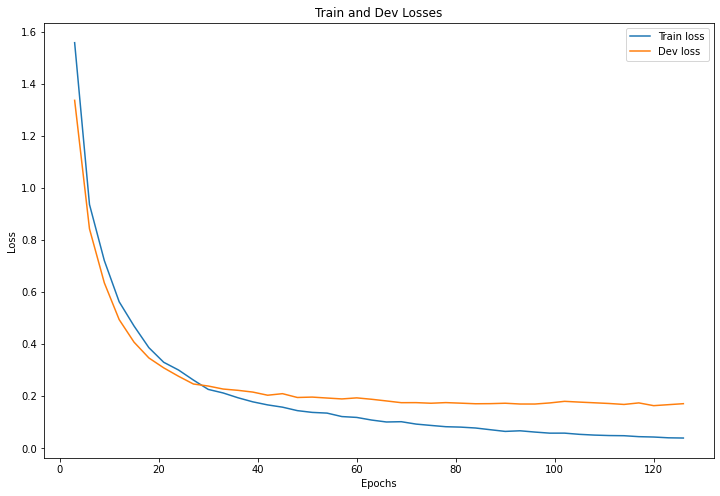

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_train[0], SNIPS_tot_losses_dev[0])

Intent loss plot 

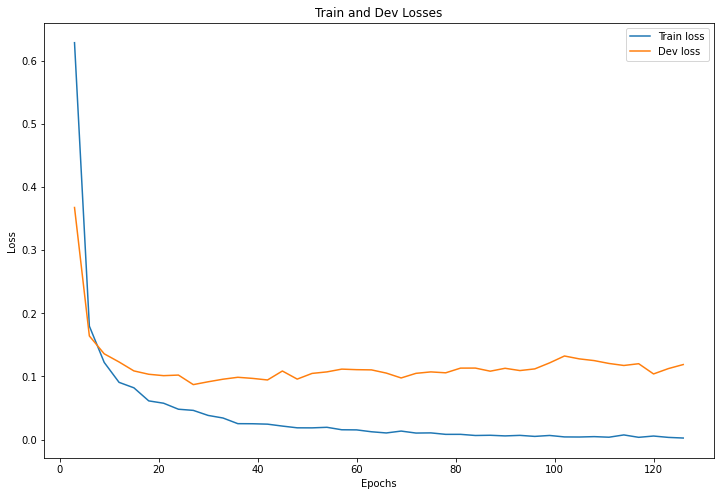

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_intent_train[0], SNIPS_tot_losses_intent_dev[0])

Slot loss plot 

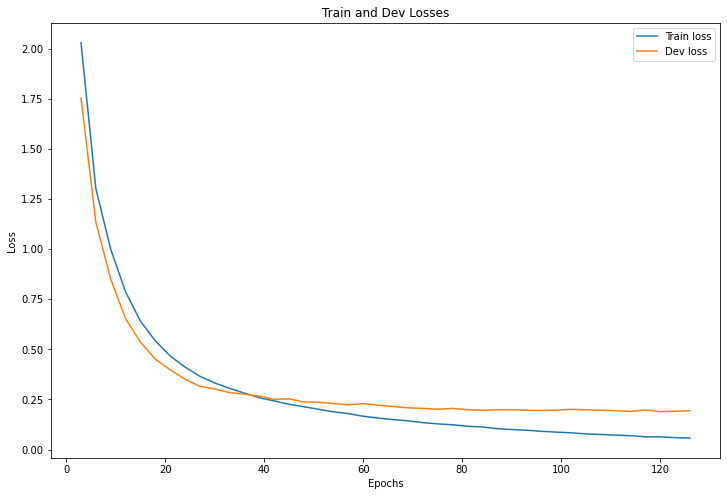

In [ ]:
plot_losses(SNIPS_tot_sampled_epochs[0], SNIPS_tot_losses_slot_train[0], SNIPS_tot_losses_slot_dev[0])

tolto voc size --> prossima cambia dropout probability (0.1)

In [ ]:
ATIS_model.load_state_dict(torch.load('/content/drive/MyDrive/NLU_trained_models/ATIS_model_bert.pt'))

In [ ]:
torch.save(ATIS_model.state_dict(), '/content/drive/MyDrive/NLU_trained_models/ATIS_model_bert.pt')

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(ATIS_sampled_epochs, ATIS_losses_train, label='Train loss')
plt.plot(ATIS_sampled_epochs, ATIS_losses_dev, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Intent Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.plot(ATIS_sampled_epochs, ATIS_loss_intent_train, label='Train intent loss')
plt.plot(ATIS_sampled_epochs, ATIS_loss_intent_dev, label='Dev intent loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Slot Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(ATIS_sampled_epochs, ATIS_loss_slot_train, label='Train slot loss')
plt.plot(ATIS_sampled_epochs, ATIS_loss_slot_dev, label='Dev slot loss')
plt.legend()
plt.show()

In [ ]:
SNIPS_model = Bert_model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

In [ ]:
lr=0.0001
SNIPS_optimizer = optim.Adam(SNIPS_model.parameters(), lr=lr) #take default parameters, just modify lr

In [ ]:
SNIPS_sampled_epochs, SNIPS_losses_train, SNIPS_losses_dev, SNIPS_loss_intent_train, SNIPS_loss_slot_train, SNIPS_loss_intent_dev, SNIPS_loss_slot_dev = train_try(
    train_loader = SNIPS_train_loader, 
    test_loader = SNIPS_test_loader, 
    dev_loader = SNIPS_dev_loader, 
    model = SNIPS_model, 
    optimizer = SNIPS_optimizer,
    lang = SNIPS_lang,
    train = True)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(SNIPS_sampled_epochs, SNIPS_losses_train, label='Train loss')
plt.plot(SNIPS_sampled_epochs, SNIPS_losses_dev, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(num = 3, figsize=(20, 12)).patch.set_facecolor('white')
plt.title('Train and Dev Intent Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.plot(SNIPS_sampled_epochs, SNIPS_loss_intent_train, label='Train intent loss')
plt.plot(SNIPS_sampled_epochs, SNIPS_loss_intent_dev, label='Dev intent loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(num = 3, figsize=(20, 12)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(SNIPS_sampled_epochs, SNIPS_loss_slot_train, label='Train slot loss')
plt.plot(SNIPS_sampled_epochs, SNIPS_loss_slot_dev, label='Dev slot loss')
plt.legend()
plt.show()

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_try2(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        #print("\nslots.shape:\n ",slots.shape)
        #print("\nsample.shape\n: ",sample['y_slots'].shape)

        #print("\nslots:\n ",slots)
        #print("\nsample\n: ",sample['y_slots'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())



        loss = 0.3*loss_intent + 0.7*loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
                                       # you can decide to give more imporante to intent or slots with a linear combination

        """#Add L2 regularization 
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.intent_out.parameters())
        
        loss = loss + l2_lambda * l2_norm"""

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop_try2(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = 0.3*loss_intent + 0.7*loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                #print(utt_ids)
                utterance = [lang.id2word[elem] for elem in utt_ids]
                #print(utterance)
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
                #print(hyp_slots)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array


In [ ]:
def train_try2(train_loader, test_loader, dev_loader, model, optimizer, lang, tokenizer, n_epochs=200, patience=3, train=True):
 
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop_try2(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop_try2(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']

            """if(x=50):
              parameters = []
              for param in model.parameters():"""

            
            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop_try2(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

In [ ]:
class Lang():
    def __init__(self, words, intents, slots, tokenizer, cutoff=0):
        self.word2id = self.w2id(words, tokenizer, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}

    #method to transform words to id 
    def w2id(self, elements, tokenizer, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                #print("k: ", k)
                #print("v: ", v)
                #print("len(vocab): ", len(vocab))
                vocab[k] = tokenizer.convert_tokens_to_ids(k)
                #print("vocab[k]: ", vocab[k])
        #pprint(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [ ]:
lr=0.0001

parameters = []

for param in ATIS_model.slot_out.parameters():
  parameters.append(param)

for param in ATIS_model.intent_out.parameters():
  parameters.append(param)

ATIS_optimizer = optim.Adam(parameters, lr=lr) #take default parameters, just modify lr

In [ ]:
import torch
import torch.utils.data as data

class IntentsAndSlotsBert(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, tokenizer, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk

        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        max_length = max(len([x.split()]) for x in self.utterances)
        
        """        
        slot_map = {}
        for label in self.slots:
            slot_map[label] = lang.slot2id(label)
        """
#convert to numbers
        self.utt_ids = self.mapping_utt(self.utterances, tokenizer, max_length)
        #self.slot_ids = self.encode_token_labels(self.utterances, self.slots, tokenizer, lang.slot2id, max_length)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample #dictionary with 3 keys
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_utt(self, utterances, tokenizer, max_length): # Map sequences to number
        token_ids = np.zeros(shape=(len(utterances), max_length+2), dtype=np.int32) #max_length +2 because of [CLS] and [SEP] tokens
        for i, utterance in enumerate(utterances):
          #print(utterance)
          encoded = tokenizer.encode(utterance)
          #print(len(encoded))
          token_ids[i, 0:len(encoded)] = encoded
        #print(token_ids)
        return token_ids

    def encode_token_labels(self, utterances, slot_names, tokenizer, slot_map, max_length):
      encoded = np.zeros(shape=(len(utterances), max_length+2), dtype=np.int32)
      for i, (utterance, word_labels) in enumerate(zip(utterances, slot_names)):
          encoded_labels = []
          for word, word_label in zip(utterance.split(), word_labels.split()):
              tokens = [word]
              encoded_labels.append(slot_map[word_label])
              expand_label = word_label.replace("B-", "I-")
              if not expand_label in slot_map:
                  expand_label = word_label
              encoded_labels.extend([slot_map[expand_label]] *\
                                      (len(tokens) - 1))
          encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
          #print(len(utterance.split()))
          #print(len(encoded_labels))

      return encoded

    def mapping_seq(self, data, mapper): # Map sequences to number
      res = []
      for seq in data:
          tmp_seq = []
          for x in seq.split():
              if x in mapper:
                  tmp_seq.append(mapper[x])
              else:
                  tmp_seq.append(mapper[self.unk])
          res.append(tmp_seq)
      return res

    def mapping_seq_old(self, data, mapper): # Map sequences to number
      res = []
      for seq in data:
          tmp_seq = []
          for x in seq.split():
              if x in mapper:
                  tmp_seq.append(mapper[x])
              else:
                  tmp_seq.append(mapper[self.unk])
          res.append(tmp_seq)
      return res


In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_try2(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        #print("\nslots.shape:\n ",slots.shape)
        #print("\nsample.shape\n: ",sample['y_slots'].shape)

        #print("\nslots:\n ",slots)
        #print("\nsample\n: ",sample['y_slots'])

        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss_intent_array.append(loss_intent.item())
        loss_slot_array.append(loss_slot.item())


        #loss = loss_intent #HO CAMBIATO IL LOSSSSSSSSSSSSSSSSSS
        loss = 0.3*loss_intent + 0.7*loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
                                       # you can decide to give more imporante to intent or slots with a linear combination

        """#Add L2 regularization 
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.intent_out.parameters())
        
        loss = loss + l2_lambda * l2_norm"""

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array, loss_intent_array, loss_slot_array

def eval_loop_try2(data, criterion_slots, criterion_intents, model, lang, tokenizer):
    model.eval()
    loss_array = []
    loss_intent_array = []
    loss_slot_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])

            #print(slots.shape)
            #print("\nutt\n:", sample["utterances"].shape)
            #print(slots)
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = 0.3*loss_intent + 0.7*loss_slot 

            loss_intent_array.append(loss_intent.item())
            loss_slot_array.append(loss_slot.item())
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]] 
                
                
                #print(utt_ids)
                #print(gt_slots)
                utterance = tokenizer.decode(utt_ids)
                utterance = utterance.split()
                #print(utterance)
                
                to_decode = seq[:length].tolist()
                
                """if len(gt_slots) > len(utterance) :
                  gt_slots.pop()
                  to_decode.pop()
                elif len(gt_slots) < len(utterance):
                  utterance.pop()
              
                print(len(gt_slots))
                print(len(utterance))"""
                #utterance = tokenizer.
                
                #print(to_decode)
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                #print(len(utterance))
                #print("len to_decode", len(to_decode))
                for id_el, elem in enumerate(to_decode):
                    #print("utterance: ", utterance[id_el])
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                    #print(tmp_seq)
                hyp_slots.append(tmp_seq)
                #print(ref_slots)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array, loss_intent_array, loss_slot_array


##separated lstm

In [ ]:
class Model_sep(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(Model_sep, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder1 = nn.LSTM(emb_size, 
                                   emb_size, 
                                   n_layer,
                                   bidirectional=True)     #network, bidirectional
        
        self.utt_encoder2 = nn.LSTM(emb_size*2, 
                                   emb_size, 
                                   n_layer,
                                   bidirectional=True) 


        #self.conv_intent = nn.Conv1d(in_channels = 300, out_channels = 200, kernel_size = 4, padding = 1)

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        self.dropout = nn.Dropout(0.6) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting


        self.slot_out = nn.Linear(600, out_slot)

        self.intent_out = nn.Linear(300, out_int)
      
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size

        

        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

        utt_emb_drop = self.dropout(utt_emb)
        
        packed_input = pack_padded_sequence(utt_emb_drop, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder1(packed_input) 

        packed_output2, (last_hidden, cell) = self.utt_encoder2(packed_output)

        #print("\n",last_hidden)
        #print(packed_input.size)
        #packed_output2, (last_hidden2, cell2) = self.utt_encoder(packed_output) 
  
        #packed output containing the output features (h_t) from the last layer of the LSTM, 
        #for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the 
        #input, the output will also be a packed sequence.

        #last_hidden containing the final hidden state for each element in the sequence
        #cell containing the final cell state for each element in the sequence
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output2)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        #print("\nutt_encoded.shape: ", utt_encoded.shape)
        #print("\nlast hidden.shape",last_hidden.shape)
        
        """
        utt_encoded = utt_encoded.permute(1,2,0)

        print("\nbefore:\n", utt_encoded.shape)

        utt_conv = self.conv_slots(utt_encoded)

        print("\nafter:\n", utt_conv.shape)

        utt_conv = utt_conv.permute(2,0,1)
        """
        
        
        
        """
        last_hidden = last_hidden.permute(1,2,0)

        hidden_conv = self.conv_intent(last_hidden)

        hidden_conv = hidden_conv.permute(2,0,1)
        """

        hidden_conv = last_hidden

        hidden_conv = hidden_conv[-1,:,:]

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(hidden_conv)
       
        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        slots = self.slot_out(drop_utt)

        #slots.shape: [sentence_lenght, batch_size, out_slots]
        #print("slots size: ", slots.shape)
        #print("\n\n",slots,"\n\n")
        
        
        #print(type(drop_hidden[0][0]))

        #FOR EACH SENT IN BATCH, SAVES THE SLOTS IN IT

        """prova = slots
        #print("\n\nprova size:", prova.shape, "\n\n")

        prova = prova.permute(1,0,2)
          
        #print(last_hidden.shape)
        sents_slots = []
        for i, sent in enumerate(prova):
          #print("\nsent:\n", sent)
          slots_in_sentence = [0] * 73
          for word in sent:
            #print("\nword:\n", word)
            pred_slot = int(torch.argmax(word))
            slots_in_sentence[pred_slot] += 1
            
          #tensor_slots = torch.tensor(slots_in_sentence).to(device)
          #print("\nlast hidden\n",last_hidden[i].shape)
          #print("\ntensor_slots.shape\n",tensor_slots.shape)
          
          # repr = torch.cat((last_hidden[i], tensor_slots))
          # new_hidden.append(list(repr))
          sents_slots.append(slots_in_sentence)

        #new_hidden = torch.tensor(new_hidden).to(device)  

        sents_slots = torch.tensor(sents_slots).to(device)  """

        intent = self.intent_out(drop_hidden)
       
        slots = slots.permute(1,2,0) # We need this for computing the loss


        return slots, intent

In [ ]:
SNIPS_model_sep = Model_sep(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_model_sep.apply(init_weights)
SNIPS_optimizer_sep = optim.Adam(SNIPS_model_sep.parameters(), lr=lr, weight_decay=wd) #take default parameters, just modify lr

In [ ]:
SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, SNIPS_losses_dev_adv = train_adv(
train_loader = SNIPS_train_loader, 
test_loader = SNIPS_test_loader, 
dev_loader = SNIPS_dev_loader, 
model = SNIPS_model_sep, 
optimizer = SNIPS_optimizer_sep,
lang = SNIPS_lang,
train = True)

In [ ]:
parameters = []

for param in SNIPS_model_sep.utt_encoder2.parameters():
  parameters.append(param)

for param in SNIPS_model_sep.slot_out.parameters():
  parameters.append(param)

SNIPS_optimizer_sep = optim.Adam(parameters, lr=lr, weight_decay=wd) #take default parameters, just modify lr

##SEPARATE CLASSIFIERS

In [ ]:
class Bert_encoder(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(Bert_encoder, self).__init__()

        config = BertConfig(vocab_size=vocab_len)
        
        self.bert = BertModel.from_pretrained("bert-base-uncased", config = config, ignore_mismatched_sizes=True)
        
    def forward(self, utterance): 

        output = self.bert(utterance) 

        return output.last_hidden_state, output.pooler_output

In [ ]:
class Slot_classifier(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self,out_slot):
        super(Slot_classifier, self).__init__()
        
        self.slot_out = nn.Linear(768, out_slot)
        
    def forward(self, hidden_slot): 

        hidden_slot = hidden_slot.permute(1,0,2) 
        
        slots = self.slot_out(hidden_slot)
       
        slots = slots.permute(1,2,0) # We need this for computing the loss

        return slots

In [ ]:
class Intent_classifier(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self,out_int):
        super(Intent_classifier, self).__init__()

        self.intent_out = nn.Linear(768, out_int)      
        
    def forward(self, pooler_output): 

        intent = self.intent_out(pooler_output)

        return intent

####Train

In [ ]:
def train_bert(train_loader, test_loader, dev_loader, encoder, slot_classifier, intent_classifier, encoder_optimizer, slot_optimizer, intent_optimizer, lang, n_epochs=200, patience=3):
 
  losses_train = []
  losses_dev = []
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      loss = train_loop_bert(train_loader, encoder_optimizer, slot_optimizer, intent_optimizer, criterion_slots, 
                        criterion_intents, encoder, slot_classifier, intent_classifier)
      if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev = eval_loop_bert(dev_loader, criterion_slots, 
                                                        criterion_intents, encoder, slot_classifier, intent_classifier, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          f1 = results_dev['total']['f']
          
          if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
              best_f1 = f1
          else:
              patience -= 1
          if patience <= 0: # Early stopping with patience
              break # Not nice but it keeps the code clean

  results_test, intent_test, _ = eval_loop_bert(test_loader, criterion_slots, 
                                          criterion_intents, encoder, slot_classifier, intent_classifier, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_bert(data, encoder_optimizer, slot_optimizer, intent_optimizer, criterion_slots, criterion_intents, encoder, slot_classifier, intent_classifier):
    encoder.train()
    slot_classifier.train()
    intent_classifier.train()
    loss_array = []
    for sample in data:
        encoder_optimizer.zero_grad()
        slot_optimizer.zero_grad()
        intent_optimizer.zero_grad()
        slots_hidden, intent_hidden = encoder(sample['utterances'])
        intent = intent_classifier(intent_hidden)
        slots = slot_classifier(slots_hidden)
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
                                       # you can decide to give more imporante to intent or slots with a linear combination
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        encoder_optimizer.step()
        slot_optimizer.step()
        intent_optimizer.step()
    return loss_array

def eval_loop_bert(data, criterion_slots, criterion_intents, encoder, slot_classifier, intent_classifier, lang):
    encoder.eval()
    slot_classifier.eval()
    intent_classifier.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots_hidden, intent_hidden = encoder(sample['utterances'])
            intents = intent_classifier(intent_hidden)
            slots = slot_classifier(slots_hidden)
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


In [ ]:
ATIS_encoder = Bert_encoder(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_slot_classifier = Slot_classifier(ATIS_out_slot).to(device)
ATIS_intent_classifier = Intent_classifier(ATIS_out_int).to(device)

In [ ]:
lr=0.0001
ATIS_encoder_optimizer = optim.Adam(ATIS_encoder.parameters(), lr=lr) #take default parameters, just modify lr
lr=0.0001
ATIS_slot_optimizer = optim.Adam(ATIS_encoder.parameters(), lr=lr) #take default parameters, just modify lr
lr=0.0001
ATIS_intent_optimizer = optim.Adam(ATIS_encoder.parameters(), lr=lr) #take default parameters, just modify lr

In [ ]:
ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev = train_bert(
    train_loader = ATIS_train_loader, 
    test_loader = ATIS_test_loader, 
    dev_loader = ATIS_dev_loader, 
    encoder = ATIS_encoder, 
    slot_classifier=ATIS_slot_classifier,
    intent_classifier=ATIS_intent_classifier,
    encoder_optimizer=ATIS_encoder_optimizer,
    slot_optimizer=ATIS_slot_optimizer,
    intent_optimizer=ATIS_intent_optimizer,
    lang = ATIS_lang)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(ATIS_sampled_epochs, ATIS_losses_train, label='Train loss')
plt.plot(ATIS_sampled_epochs, ATIS_losses_dev, label='Dev loss')
plt.legend()
plt.show()

#Try convolution

In [ ]:
class Model_adv(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(Model_adv, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   bidirectional=True)     #network, bidirectional


        self.conv_intent = nn.Conv1d(in_channels = 200, out_channels = 100, kernel_size = 3, padding =1)

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        self.dropout = nn.Dropout(0.7) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting


        self.slot_out = nn.Linear(hid_size*2, out_slot)

        self.intent_out = nn.Linear(100, out_int)
      
        #self.dropout = nn.Dropout(0.7) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 

        #print("\n",last_hidden)
        #print(packed_input.size)
        #packed_output2, (last_hidden2, cell2) = self.utt_encoder(packed_output) 
  
        #packed output containing the output features (h_t) from the last layer of the LSTM, 
        #for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the 
        #input, the output will also be a packed sequence.

        #last_hidden containing the final hidden state for each element in the sequence
        #cell containing the final cell state for each element in the sequence
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        #print("\nutt_encoded.shape: ", utt_encoded.shape)
        #print("\nlast hidden.shape",last_hidden.shape)
        
        """
        utt_encoded = utt_encoded.permute(1,2,0)

        print("\nbefore:\n", utt_encoded.shape)

        utt_conv = self.conv_slots(utt_encoded)

        print("\nafter:\n", utt_conv.shape)

        utt_conv = utt_conv.permute(2,0,1)
        """
        
        last_hidden = last_hidden.permute(1,2,0)

        """hidden_conv = self.conv_intent(last_hidden)

        hidden_conv = hidden_conv.permute(2,0,1)

        hidden_conv = hidden_conv[-1,:,:]"""

        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(last_hidden)
       
        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        slots = self.slot_out(drop_utt)
        #slots.shape: [sentence_lenght, batch_size, out_slots]
        #print("slots size: ", slots.shape)
        #print("\n\n",slots,"\n\n")
        
        """
        prova = slots
        #print("\n\nprova size:", prova.shape, "\n\n")

        prova = prova.permute(1,0,2)
          
        #print(last_hidden.shape)
        new_hidden = []
        for i, sent in enumerate(prova):
          #print("\nsent:\n", sent)
          slots_in_sentence = [0] * 73
          for word in sent:
            #print("\nword:\n", word)
            pred_slot = int(torch.argmax(word))
            slots_in_sentence[pred_slot] += 1 
          #tensor_pred_slots = torch.tensor(pred_slots).to(device)
          #last_hidden[i] = torch.cat((last_hidden[i], tensor_pred_slots))
          #print("\npred_slots\n", slots_in_sentence)
          tensor_slots = torch.tensor(slots_in_sentence).to(device)
          #print("\nlast hidden\n",last_hidden[i].shape)
          #print("\ntensor_slots.shape\n",tensor_slots.shape)
          repr = torch.cat((last_hidden[i], tensor_slots))
          new_hidden.append(list(repr))
        new_hidden = torch.tensor(new_hidden).to(device)  
        #print("\n New hidden SHAPE\n",new_hidden.shape)
        #last_hidden[i] = new_hidden
        """

        #print(last_hidden.shape)
        #utt_encoded[1] = torch.cat((utt_encoded[1], slots[2]))
        #utt_and_slot = torch.cat((utt_encoded, slots[2]), dim=1) 
        #print("\nutt_and_slot.shape: ", utt_encoded.shape)

        # Compute intent logits
        #intent = self.intent_out(last_hidden)

        #drop_hidden = self.dropout(last_hidden)

        intent = self.intent_out(drop_hidden)
        #print(intent.shape)

        #intent.shape: [128, out_intent] --> [batch_size, possible slots in dataset]
        
        #print("\n intent.shape: \n", intent.shape)
        #print("\n slots.shape first: \n", slots.shape)
        #print("\n intent: \n", intent)
        #print("\n slots first: \n", slots)


        # Slot size: [seq_len, batch size, out_slot] 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: [batch_size, out_slot, seq_len]

        return slots, intent

In [ ]:
class Model_adv(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(Model_adv, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   bidirectional=True)     #network, bidirectional



        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        self.dropout = nn.Dropout(0.7) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting

        self.slot_out = nn.Linear(hid_size*2, out_slot)

        self.intent_out = nn.Linear(hid_size, out_int)
      
        #self.dropout = nn.Dropout(0.7) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 

        #print("\n",last_hidden)
        #print(packed_input.size)
        #packed_output2, (last_hidden2, cell2) = self.utt_encoder(packed_output) 
  
        #packed output containing the output features (h_t) from the last layer of the LSTM, 
        #for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the 
        #input, the output will also be a packed sequence.

        #last_hidden containing the final hidden state for each element in the sequence
        #cell containing the final cell state for each element in the sequence
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        last_hidden = last_hidden[-1,:,:]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        #print("\nutt_encoded.shape: ", utt_encoded.shape)
        #print("\nlast hidden.shape",last_hidden.shape)
        
        drop_utt = self.dropout(utt_encoded)
        drop_hidden = self.dropout(last_hidden)
       
        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        slots = self.slot_out(drop_utt)
        #slots.shape: [sentence_lenght, batch_size, out_slots]
        #print("slots size: ", slots.shape)
        #print("\n\n",slots,"\n\n")
        #print("\nslots_before.shape:\n", slots.shape)
        """
        prova = slots
        #print("\n\nprova size:", prova.shape, "\n\n")

        prova = prova.permute(1,0,2)
          
        #print(last_hidden.shape)
        new_hidden = []
        for i, sent in enumerate(prova):
          #print("\nsent:\n", sent)
          slots_in_sentence = [0] * 73
          for word in sent:
            #print("\nword:\n", word)
            pred_slot = int(torch.argmax(word))
            slots_in_sentence[pred_slot] += 1 
          #tensor_pred_slots = torch.tensor(pred_slots).to(device)
          #last_hidden[i] = torch.cat((last_hidden[i], tensor_pred_slots))
          #print("\npred_slots\n", slots_in_sentence)
          tensor_slots = torch.tensor(slots_in_sentence).to(device)
          #print("\nlast hidden\n",last_hidden[i].shape)
          #print("\ntensor_slots.shape\n",tensor_slots.shape)
          repr = torch.cat((last_hidden[i], tensor_slots))
          new_hidden.append(list(repr))
        new_hidden = torch.tensor(new_hidden).to(device)  
        #print("\n New hidden SHAPE\n",new_hidden.shape)
        #last_hidden[i] = new_hidden
        """

        #print(last_hidden.shape)
        #utt_encoded[1] = torch.cat((utt_encoded[1], slots[2]))
        #utt_and_slot = torch.cat((utt_encoded, slots[2]), dim=1) 
        #print("\nutt_and_slot.shape: ", utt_encoded.shape)

        # Compute intent logits
        #intent = self.intent_out(last_hidden)

        #drop_hidden = self.dropout(last_hidden)

        intent = self.intent_out(drop_hidden)
        #print(intent.shape)

        #intent.shape: [128, out_intent] --> [batch_size, possible slots in dataset]
        
        #print("\n intent.shape: \n", intent.shape)
        #print("\n slots.shape first: \n", slots.shape)
        #print("\n intent: \n", intent)
        #print("\n slots first: \n", slots)


        # Slot size: [seq_len, batch size, out_slot] 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: [batch_size, out_slot, seq_len]

        return slots, intent

PROVO 2 LSTM

In [ ]:
class Model_both(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(Model_both, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
      
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   bidirectional=False)     #network, bidirectional

        self.intent_LSTM = nn.LSTM(hid_size, 
                                  hid_size, 
                                  n_layer,
                                  bidirectional=False) 

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
        self.dropout = nn.Dropout(0.1) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting

        self.slot_out = nn.Linear(hid_size, out_slot)

        self.intent_out = nn.Linear(hid_size, out_int)
      
        #self.dropout = nn.Dropout(0.7) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting
        
    def forward(self, utterance, seq_lengths, both_LSTM): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 

        
        if both_LSTM:
          packed_output, (last_hidden, cell) = self.intent_LSTM(packed_output)
          
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 
        #print(utt_encoded.shape)
        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        last_hidden = last_hidden[-1,:,:]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        #print("\nutt_encoded.shape: ", utt_encoded.shape)
        #print("\nlast hidden.shape",last_hidden.shape)
        
        #drop_utt = self.dropout(utt_encoded)

        # Compute slot logits, i use the encoded representation of the utterance, with the encoding of each word
        
        #slots.shape: [sentence_lenght, batch_size, out_slots]
        intent = self.intent_out(last_hidden)
        
        if not both_LSTM:
          slots = self.slot_out(utt_encoded)
          slots = slots.permute(1,2,0) # We need this for computing the loss
        else:
          slots = None
        #print(intent.shape)

        #intent.shape: [128, out_intent] --> [batch_size, possible slots in dataset]

        # Slot size: [seq_len, batch size, out_slot] 
       
        # Slot size: [batch_size, out_slot, seq_len]

        return slots, intent

TRAIN BOTH

In [ ]:
def train_adv(train_loader, test_loader, dev_loader, model, optimizer, lang, both_LSTM, n_epochs=200, patience=8):
 
  losses_train = []
  losses_dev = []
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      loss = train_loop_adv(train_loader, optimizer, criterion_slots, 
                        criterion_intents, model, both_LSTM)
      if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev = eval_loop_adv(dev_loader, criterion_slots, 
                                                        criterion_intents, model, lang, both_LSTM)
          losses_dev.append(np.asarray(loss_dev).mean())
          f1 = results_dev['total']['f']
          
          if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
              best_f1 = f1
          else:
              patience -= 1
          if patience <= 0: # Early stopping with patience
              break # Not nice but it keeps the code clean

  results_test, intent_test, _ = eval_loop_adv(test_loader, criterion_slots, 
                                          criterion_intents, model, lang, both_LSTM)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_adv(data, optimizer, criterion_slots, criterion_intents, model, both_LSTM):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(utterance = sample['utterances'], seq_lengths = sample['slots_len'], both_LSTM = both_LSTM)
        loss_intent = criterion_intents(intent, sample['intents'])
        loss = loss_intent # In joint training we sum the losses. 
                                       # Is there another way to do that?
                                       # you can decide to give more imporante to intent or slots with a linear combination
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_adv(data, criterion_slots, criterion_intents, model, lang, both_LSTM):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'], both_LSTM)
            loss_intent = criterion_intents(intents, sample['intents'])
            
            loss = loss_intent
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            if not both_LSTM:
              # Slot inference 
              output_slots = torch.argmax(slots, dim=1)
              for id_seq, seq in enumerate(output_slots):
                  length = sample['slots_len'].tolist()[id_seq]
                  utt_ids = sample['utterance'][id_seq][:length].tolist()
                  gt_ids = sample['y_slots'][id_seq].tolist()
                  gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                  utterance = [lang.id2word[elem] for elem in utt_ids]
                  to_decode = seq[:length].tolist()
                  ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                  tmp_seq = []
                  for id_el, elem in enumerate(to_decode):
                      tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                  hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


In [ ]:
SNIPS_model_both = Model_both(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_model_both.apply(init_weights)
SNIPS_optimizer_adv = optim.Adam(SNIPS_model_both.parameters(), lr=lr, weight_decay=wd) #take default parameters, just modify lr

In [ ]:
SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, SNIPS_losses_dev_adv = train_adv(
  train_loader = SNIPS_train_loader, 
  test_loader = SNIPS_test_loader, 
  dev_loader = SNIPS_dev_loader, 
  model = SNIPS_model_both, 
  optimizer = SNIPS_optimizer_adv,
  lang = SNIPS_lang,
  both_LSTM = False)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, label='Train loss')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_dev_adv, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, SNIPS_losses_dev_adv = train_adv(
train_loader = SNIPS_train_loader, 
test_loader = SNIPS_test_loader, 
dev_loader = SNIPS_dev_loader, 
model = SNIPS_model_both, 
optimizer = SNIPS_optimizer_adv,
lang = SNIPS_lang,
both_LSTM = True)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, label='Train loss')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_dev_adv, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
class Encoder(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(Encoder, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #A simple lookup table that stores embeddings of a fixed dictionary and size.
        #The input to the module is a list of indices, and the output is the corresponding word embeddings.
        
        self.embedding = nn.Embedding(vocab_len, 
                                      emb_size, 
                                      padding_idx=pad_index) #pad idx --> the entities at pad_index do not contribute to the gradient
        
        """
        num_embeddings (int) – size of the dictionary of embeddings

        embedding_dim (int) – the size of each embedding vector

        padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient; 
        """
        self.utt_encoder = nn.LSTM(emb_size, 
                                   hid_size, 
                                   n_layer,
                                   bidirectional=True)     #network, bidirectional

        """  
        input_size – The number of expected features in the input x
        hidden_size – The number of features in the hidden state h
        num_layers – Number of recurrent layers. 
        """
      
        
    def forward(self, utterance, seq_lengths): #define the architecture
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #--> get word embedding
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        last_hidden = last_hidden[-1,:,:]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        return last_hidden

In [ ]:
SNIPS_model_adv = Encoder(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_model_adv.apply(init_weights)
SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr, weight_decay=wd) #take default parameters, just modify lr

In [ ]:
SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, SNIPS_losses_dev_adv = train_adv(
train_loader = SNIPS_train_loader, 
test_loader = SNIPS_test_loader, 
dev_loader = SNIPS_dev_loader, 
model = SNIPS_model_adv, 
optimizer = SNIPS_optimizer_adv,
lang = SNIPS_lang)

In [ ]:
SNIPS_model_adv.slot_out = nn.Identity()
SNIPS_model_adv.intent_out = nn.Identity()

In [ ]:
print(SNIPS_model_adv)

In [ ]:
class Intent_LSTM(nn.Module):
#hidden size of rnn, embedding size (size of the vector that represent the word embedding)
    def __init__(self, hid_size, out_int, vocab_len, n_layer=1, pad_index=0):
        super(Intent_LSTM, self).__init__()

        self.final_hidden = nn.LSTM(200, 
                                   200, 
                                   n_layer,
                                   bidirectional=False)     #network, bidirectional

        self.dropout = nn.Dropout(0.1) #regularization --> randomly mute a neuron, only on training phase. Helps to avoid overfitting

        self.intent_out = nn.Linear(hid_size, out_int)
      
        
    def forward(self, hidden_repr): #define the architecture
        # Process the batch
        #print(len(hidden_repr[0]))
        hidden_tensor = torch.Tensor(hidden_repr[0])
        print(hidden_tensor.shape)
        packed_output, (last_hidden, cell) = self.final_hidden(hidden_repr[0]) 
        
        #utt_encoded.shape: [sentence lenght, 128, 200] 

        # Get the last hidden state
        #last_hidde.shape: [1, 128, 200]
        print("last hidden shape", last_hidden.shape)
        last_hidden = last_hidden[-1,:,:]
        #last_hidde.shape: [128, 200] -> [batch size, hidden_size]

        intent = self.intent_out(last_hidden)

        return intent

In [ ]:
SNIPS_intent_LSTM = Intent_LSTM(hid_size, SNIPS_out_int, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

In [ ]:
SNIPS_intent_LSTM.apply(init_weights)
SNIPS_optimizer_intent = optim.Adam(SNIPS_intent_LSTM.parameters(), lr=lr) #take default parameters, just modify lr

In [ ]:
print(SNIPS_intent_LSTM)

In [ ]:
SNIPS_sampled_epochs_final, SNIPS_losses_train_final, SNIPS_losses_dev_final = train_intent_LSTM(
train_loader = SNIPS_train_loader, 
test_loader = SNIPS_test_loader, 
dev_loader = SNIPS_dev_loader, 
encoder = SNIPS_model_adv,
model = SNIPS_intent_LSTM, 
optimizer = SNIPS_optimizer_intent,
lang = SNIPS_lang)

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_intent_LSTM(data, optimizer, criterion_slots, criterion_intents, encoder, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        hidden = encoder(sample['utterances'], sample['slots_len'])
        print("hidden_shape: ", torch.Tensor(hidden).shape)
        final = model(hidden)
        loss_intent = criterion_intents(final, sample['intents'])
        loss = loss_intent  # In joint training we sum the losses. 
                            # Is there another way to do that?
                            # you can decide to give more imporante to intent or slots with a linear combination
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_intent_LSTM(data, criterion_slots, criterion_intents, encoder, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            hidden = encoder(sample['utterances'], sample['slots_len'])
            final = model(hidden)
            loss_intent = criterion_intents(final, sample['intents'])
            loss = loss_intent
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(final, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return report_intent, loss_array

In [ ]:
def train_intent_LSTM(train_loader, test_loader, dev_loader,encoder, model, optimizer, lang, n_epochs=200, patience=3):
 
  losses_train = []
  losses_dev = []
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      loss = train_loop_intent_LSTM(train_loader, optimizer, criterion_slots, 
                        criterion_intents, encoder, model)
      if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev = eval_loop_adv(dev_loader, criterion_slots, 
                                                        criterion_intents, encoder, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          f1 = results_dev['total']['f']
          
          if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
              best_f1 = f1
          else:
              patience -= 1
          if patience <= 0: # Early stopping with patience
              break # Not nice but it keeps the code clean

  results_test, intent_test, _ = eval_loop_adv(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev

In [ ]:
ATIS_model_adv = Model_adv(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_model_adv.apply(init_weights)
ATIS_optimizer_adv = optim.Adam(ATIS_model_adv.parameters(), lr=lr, weight_decay=wd) #take default parameters, just modify lr

In [ ]:
ATIS_sampled_epochs_adv, ATIS_losses_train_adv, ATIS_losses_dev_adv = train(
    train_loader = ATIS_train_loader, 
    test_loader = ATIS_test_loader, 
    dev_loader = ATIS_dev_loader, 
    model = ATIS_model_adv, 
    optimizer = ATIS_optimizer_adv,
    lang = ATIS_lang)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(ATIS_sampled_epochs_adv, ATIS_losses_train_adv, label='Train loss')
plt.plot(ATIS_sampled_epochs_adv, ATIS_losses_dev_adv, label='Dev loss')
plt.legend()
plt.show()

Third model

In [ ]:
# BERT model script from: huggingface.co
from transformers import BertModel #tokenizer + architecture (actual weights)

model = BertModel.from_pretrained("bert-base-uncased")

outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

##Train

In [ ]:
import torch.optim as optim

hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient #clip gradient to a threshold (hyperparameter)

In [ ]:
SNIPS_model_adv = Model_adv(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_model_adv.apply(init_weights)
SNIPS_optimizer_adv = optim.Adam(SNIPS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr

In [ ]:
SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, SNIPS_losses_dev_adv = train_adv(
train_loader = SNIPS_train_loader, 
test_loader = SNIPS_test_loader, 
dev_loader = SNIPS_dev_loader, 
model = SNIPS_model_adv, 
optimizer = SNIPS_optimizer_adv,
lang = SNIPS_lang,
train = True)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_train_adv, label='Train loss')
plt.plot(SNIPS_sampled_epochs_adv, SNIPS_losses_dev_adv, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
ATIS_model_adv = Model_adv(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_model_adv.apply(init_weights)
lr=0.0001
ATIS_optimizer_adv = optim.Adam(ATIS_model_adv.parameters(), lr=lr) #take default parameters, just modify lr

In [ ]:
ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev = train_adv(
    train_loader = ATIS_train_loader, 
    test_loader = ATIS_test_loader, 
    dev_loader = ATIS_dev_loader, 
    model = ATIS_model, 
    optimizer = ATIS_optimizer,
    lang = ATIS_lang)

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(ATIS_sampled_epochs, ATIS_losses_train, label='Train loss')
plt.plot(ATIS_sampled_epochs, ATIS_losses_dev, label='Dev loss')
plt.legend()
plt.show()

In [ ]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop_adv(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])

        #print("\nslots.shape:\n ",slots.shape)
        #print("\nsample.shape\n: ",sample['y_slots'].shape)

        #print("\nslots:\n ",slots)
        #print("\nsample\n: ",sample['y_slots'])

        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
                                       # you can decide to give more imporante to intent or slots with a linear combination
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_adv(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


In [ ]:
def train_adv(train_loader, test_loader, dev_loader, model, optimizer, lang, n_epochs=200, patience=3, train=True):
 
  losses_train = []
  losses_dev = []
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss = train_loop_adv(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop_adv(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']
            
            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ = eval_loop_adv(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev

In [ ]:
def train_try(train_loader, test_loader, dev_loader, model, optimizer, lang, n_epochs=200, patience=3, train=True):
 
  losses_train = []
  loss_intent_train = []
  loss_slot_train = []
  losses_dev = [] 
  loss_intent_dev_array = []
  loss_slot_dev_array= []

  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
      if train:
        loss, loss_intent, loss_slot = train_loop_try(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 3 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            loss_intent_train.append(np.asarray(loss_intent).mean())
            loss_slot_train.append(np.asarray(loss_slot).mean())

            results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop_try(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
            loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
            f1 = results_dev['total']['f']

            """if(x=50):
              parameters = []
              for param in model.parameters():"""

            
            if f1 > best_f1: #sometimes loss words but f1 increases, we have to look at both and figure out what of the 2 to use to stop the training
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

  results_test, intent_test, _ , _ , _ = eval_loop_try(test_loader, criterion_slots, 
                                          criterion_intents, model, lang)    
  print('\nSlot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])
  return sampled_epochs, losses_train, losses_dev, loss_intent_train, loss_slot_train, loss_intent_dev_array, loss_slot_dev_array

In [ ]:
def train_multiple_runs_try(train_loader, test_loader, dev_loader, model, criterion_slots, criterion_intents, optimizer, lang, n_epochs=200, patience=3, runs=5):
  slot_f1s, intent_acc = [], []
  tot_losses_train, tot_losses_dev = [], []
  tot_losses_intent_train, tot_losses_intent_dev = [], []
  tot_losses_slot_train, tot_losses_slot_dev = [], []
  tot_sampled_epochs = []

  for x in tqdm(range(0, runs)):
      model.apply(init_weights)

      losses_train = []
      losses_dev = []
      loss_intent_train = []
      loss_slot_train = []
      loss_intent_dev_array = []
      loss_slot_dev_array= []

      sampled_epochs = []
      best_f1 = 0
      for x in tqdm(range(1,n_epochs)):
          loss, loss_intent, loss_slot = train_loop_try(train_loader, optimizer, criterion_slots, 
                            criterion_intents, model)
          if x % 5 == 0:
              sampled_epochs.append(x)
              losses_train.append(np.asarray(loss).mean())
              loss_intent_train.append(np.asarray(loss_intent).mean())
              loss_slot_train.append(np.asarray(loss_slot).mean())
              
              results_dev, intent_res, loss_dev, loss_intent_dev, loss_slot_dev = eval_loop_try(dev_loader, criterion_slots, 
                                                            criterion_intents, model, lang)
              losses_dev.append(np.asarray(loss_dev).mean())
              loss_intent_dev_array.append(np.asarray(loss_intent_dev).mean())
              loss_slot_dev_array.append(np.asarray(loss_slot_dev).mean())
              f1 = results_dev['total']['f']

              if f1 > best_f1:
                  best_f1 = f1
              else:
                  patience -= 1
              if patience <= 0: # Early stoping with patient
                  break # Not nice but it keeps the code clean

      results_test, intent_test, _ , _ , _  = eval_loop_try(test_loader, criterion_slots, 
                                              criterion_intents, model, lang)
      intent_acc.append(intent_test['accuracy'])
      slot_f1s.append(results_test['total']['f'])
      tot_losses_train.append(losses_train)
      tot_losses_dev.append(losses_dev)
      tot_losses_intent_train.append(loss_intent_train)
      tot_losses_intent_dev.append(loss_intent_dev_array)
      tot_losses_slot_train.append(loss_slot_train)
      tot_losses_slot_dev.append(loss_slot_dev_array) 
      tot_sampled_epochs.append(sampled_epochs)

  slot_f1s = np.asarray(slot_f1s)
  intent_acc = np.asarray(intent_acc)
  print('\nSlot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
  print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))
  return tot_sampled_epochs, tot_losses_train, tot_losses_dev, tot_losses_intent_train, tot_losses_slot_train, tot_losses_intent_dev, tot_losses_slot_dev

In [ ]:
fdict = {}
for k, v in ATIS_tot_intent_test[0].items():
  fdict[k] = v['f1-score']

plt.barh(list(fdict.keys()), list(fdict.values()), align = 'center')
plt.show()

In [ ]:
SNIPS_tot_intent_test[0].pop('accuracy')
fdict = {}
for k, v in SNIPS_tot_intent_test[0].items():
  fdict[k] = v['f1-score']

plt.barh(list(fdict.keys()), list(fdict.values()), align = 'center')
plt.show()